In [4]:
from google.colab import files

# 로컬에서 파일 업로드
uploaded = files.upload()

Saving catsanddogs.png to catsanddogs.png


In [5]:
import os

# 업로드된 파일 확인
print("📂 현재 Colab에 업로드된 파일 목록:")
os.listdir("/content/")

# 이미지 경로 설정
img_path = "/content/catsanddogs.png"
print(f"✅ 이미지 경로 설정 완료: {img_path}")

📂 현재 Colab에 업로드된 파일 목록:
✅ 이미지 경로 설정 완료: /content/catsanddogs.png


In [6]:
import os

# Colab에 업로드된 파일 목록 출력
print("📂 현재 Colab의 파일 목록:")
os.listdir("/content/")

📂 현재 Colab의 파일 목록:


['.config', 'catsanddogs.png', 'sample_data']

#Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

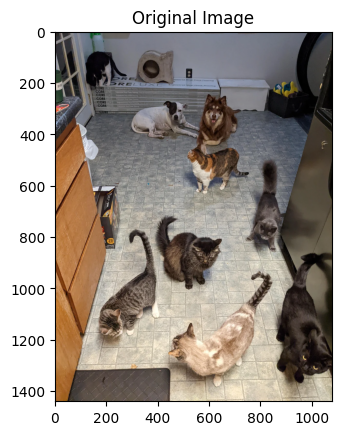

In [7]:
import cv2
import matplotlib.pyplot as plt

# 이미지 불러오기 (BGR -> RGB 변환 필요)
img_orig = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)  # OpenCV는 기본적으로 BGR로 이미지를 불러옴

# 이미지 시각화
plt.imshow(img_rgb)
plt.axis('on')  # 축 제거
plt.title('Original Image')
plt.show()

In [2]:
import os
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")  # 환경 변수로 설정된 토큰 가져오기
login(token=HF_TOKEN)

In [16]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# 모델 선택 (CityScapes 기반)
model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

print("✅ SegFormer 모델 로딩 완료! (CityScapes)")

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

✅ SegFormer 모델 로딩 완료! (CityScapes)


In [17]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# 모델 선택 (ADE20K 기반, 기존 모델과 유사)
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

print("✅ SegFormer 모델 로딩 완료! (ADE20K)")

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

✅ SegFormer 모델 로딩 완료! (ADE20K)


In [18]:
import torch

# 이미지 변환 (모델 입력에 맞게 조정)
inputs = feature_extractor(images=img_rgb, return_tensors="pt")

# 모델을 GPU로 옮길 수 있는 경우 옮기기
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 전처리된 이미지도 GPU로 옮기기
inputs = {k: v.to(device) for k, v in inputs.items()}

print(f"✅ 이미지 전처리 완료! (Device: {device})")

✅ 이미지 전처리 완료! (Device: cuda)


In [19]:
# 모델 예측 수행
with torch.no_grad():
    outputs = model(**inputs)

# 출력 logits을 가장 높은 확률을 가진 클래스로 변환
logits = outputs.logits
seg_map = logits.argmax(dim=1).squeeze().cpu().numpy()

print("✅ 세그멘테이션 완료!")

✅ 세그멘테이션 완료!


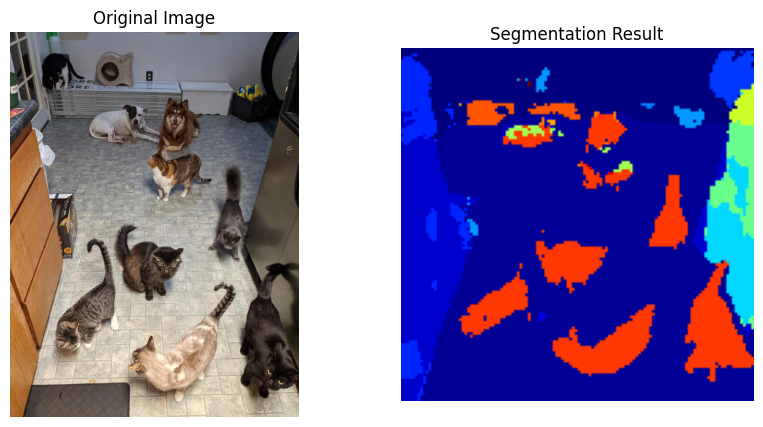

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 세그멘테이션 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 세그멘테이션 결과 (색상맵 적용)
plt.subplot(1, 2, 2)
plt.imshow(seg_map, cmap="jet")
plt.axis("off")
plt.title("Segmentation Result")

plt.show()

In [21]:
# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

🔍 감지된 클래스 ID: [  0   3   4   7  10  12  13  24  27  37  41  50  71  81  89 108 112 115
 121 126 137 148]


In [23]:
# ADE20K 데이터셋 클래스 리스트 불러오기
!wget -q https://raw.githubusercontent.com/CSAILVision/sceneparsing/master/objectInfo150.txt -O objectInfo150.txt

# 파일에서 클래스 매핑 로드 (첫 줄 건너뛰기)
class_labels = {}
with open("objectInfo150.txt", "r") as f:
    next(f)  # 첫 줄 건너뛰기
    for line in f.readlines():
        parts = line.strip().split()
        class_id = int(parts[0])  # 숫자로 변환 가능
        class_name = " ".join(parts[1:])  # 클래스 이름
        class_labels[class_id] = class_name

# 모델이 감지한 클래스 출력
detected_classes = {class_id: class_labels.get(class_id, "Unknown") for class_id in unique_classes}
print("🔍 감지된 클래스 매핑:", detected_classes)

🔍 감지된 클래스 매핑: {0: 'Unknown', 3: '0.0878 8265 796 sky', 4: '0.0621 9336 917 floor, flooring', 7: '0.0398 4023 408 road, route', 10: '0.0183 2423 225 grass', 12: '0.0166 3068 310 sidewalk, pavement', 13: '0.0160 5075 526 person, individual, someone, somebody, mortal, soul', 24: '0.0065 1191 106 sofa, couch, lounge', 27: '0.0053 651 57 sea', 37: '0.0026 3089 302 lamp', 41: '0.0023 411 37 base, pedestal, stand', 50: '0.0018 468 38 fireplace, hearth, open fireplace', 71: '0.0012 331 31 countertop', 81: '0.0009 248 25 bus, autobus, coach, charabanc, double-decker, jitney, motorbus, motorcoach, omnibus, passenger vehicle', 89: '0.0007 71 5 booth, cubicle, stall, kiosk', 108: '0.0005 77 9 washer, automatic washer, washing machine', 112: '0.0005 50 4 barrel, cask', 115: '0.0005 59 3 tent, collapsible shelter', 121: '0.0005 116 24 food, solid food', 126: '0.0004 1193 139 pot, flowerpot', 137: '0.0003 528 65 traffic light, traffic signal, stoplight', 148: '0.0002 504 57 glass, drinking glass'}


In [24]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# COCO 데이터셋을 기반으로 훈련된 DeepLabV3 모델 불러오기
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

print("✅ DeepLabV3 (COCO) 모델 로딩 완료!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s]


✅ DeepLabV3 (COCO) 모델 로딩 완료!


In [25]:
# 이미지 불러오기 (OpenCV 사용)
img_path = "/content/catsanddogs.png"
img_orig = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환

# 모델 입력 크기와 맞추기 (Normalize & Resize)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),  # 모델 기본 입력 크기
    transforms.ToTensor(),
])

# 이미지 변환
input_tensor = transform(img_rgb).unsqueeze(0)  # 배치 차원 추가
print(f"✅ 이미지 전처리 완료! (입력 크기: {input_tensor.shape})")

✅ 이미지 전처리 완료! (입력 크기: torch.Size([1, 3, 520, 520]))


In [26]:
import torch
from torchvision import models

# 모델 로드 (DeepLabV3 + ResNet101, COCO 데이터셋 기반)
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
model = model.to(device)  # GPU 사용 가능하면 이동

# 모델 예측 실행
with torch.no_grad():
    input_tensor = input_tensor.to(device)  # GPU로 이동
    output = model(input_tensor)["out"]  # 모델 실행
    seg_map = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()

print("✅ 세그멘테이션 완료!")

✅ 세그멘테이션 완료!


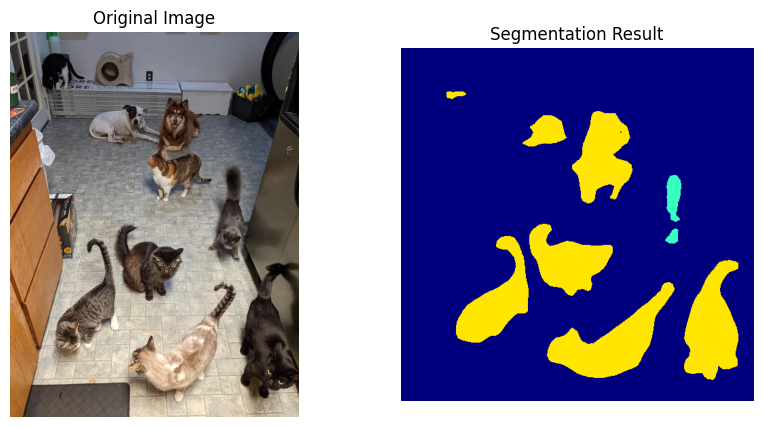

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 세그멘테이션 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 세그멘테이션 결과 (색상맵 적용)
plt.subplot(1, 2, 2)
plt.imshow(seg_map, cmap="jet")  # Jet 컬러맵 적용
plt.axis("off")
plt.title("Segmentation Result")

plt.show()

In [29]:
# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

# COCO 데이터셋의 클래스 매핑 (고양이 클래스 ID: 17)
COCO_CLASS_MAPPING = {
    0: "Background",
    1: "Person",
    2: "Bicycle",
    3: "Car",
    4: "Motorcycle",
    5: "Airplane",
    6: "Bus",
    7: "Train",
    8: "Truck",
    9: "Boat",
    10: "Traffic Light",
    11: "Fire Hydrant",
    13: "Stop Sign",
    14: "Parking Meter",
    15: "Bench",
    16: "Bird",
    17: "Cat",  # 고양이 클래스 ID
    18: "Dog",
    19: "Horse",
    20: "Sheep",
    21: "Cow",
    22: "Elephant",
    23: "Bear",
    24: "Zebra",
    25: "Giraffe"
}

# 감지된 클래스 매핑 출력
detected_classes = {class_id: COCO_CLASS_MAPPING.get(class_id, "Unknown") for class_id in unique_classes}
print("🔍 감지된 클래스 매핑:", detected_classes)

# 고양이 클래스 ID 확인
if 17 in unique_classes:
    print("✅ 고양이 클래스(17) 감지됨!")
else:
    print("❌ 고양이 클래스가 감지되지 않았습니다.")

🔍 감지된 클래스 ID: [ 0  5  8 12]
🔍 감지된 클래스 매핑: {0: 'Background', 5: 'Airplane', 8: 'Truck', 12: 'Unknown'}
❌ 고양이 클래스가 감지되지 않았습니다.


In [31]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# DeepLabV3+ (PASCAL VOC) 모델 선택
model_name = "nvidia/segformer-b2-finetuned-ade-512-512"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)

print("✅ DeepLabV3+ (PASCAL VOC) 모델 로딩 완료!")

✅ DeepLabV3+ (PASCAL VOC) 모델 로딩 완료!


In [32]:
import torch

# 이미지 변환 (모델 입력에 맞게 조정)
inputs = feature_extractor(images=img_rgb, return_tensors="pt")

# 모델을 GPU로 옮길 수 있는 경우 옮기기
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 전처리된 이미지도 GPU로 옮기기
inputs = {k: v.to(device) for k, v in inputs.items()}

print(f"✅ 이미지 전처리 완료! (Device: {device})")

✅ 이미지 전처리 완료! (Device: cuda)


In [33]:
# 모델 예측 수행
with torch.no_grad():
    outputs = model(**inputs)

# 출력 logits을 가장 높은 확률을 가진 클래스로 변환
logits = outputs.logits
seg_map = logits.argmax(dim=1).squeeze().cpu().numpy()

print("✅ 세그멘테이션 완료!")

✅ 세그멘테이션 완료!


In [34]:
import numpy as np

# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

🔍 감지된 클래스 ID: [  0   3   4   7  10  12  13  24  27  37  41  50  71  81  89 108 112 115
 121 126 137 148]


In [35]:
# PASCAL VOC 클래스 리스트
VOC_CLASSES = [
    "Background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus",
    "Car", "Cat", "Chair", "Cow", "Dining Table", "Dog", "Horse", "Motorbike",
    "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV/Monitor"
]

# 모델이 감지한 클래스 출력
detected_classes = {class_id: VOC_CLASSES[class_id] if class_id < len(VOC_CLASSES) else "Unknown"
                    for class_id in unique_classes}
print("🔍 감지된 클래스 매핑:", detected_classes)

🔍 감지된 클래스 매핑: {0: 'Background', 3: 'Bird', 4: 'Boat', 7: 'Car', 10: 'Cow', 12: 'Dog', 13: 'Horse', 24: 'Unknown', 27: 'Unknown', 37: 'Unknown', 41: 'Unknown', 50: 'Unknown', 71: 'Unknown', 81: 'Unknown', 89: 'Unknown', 108: 'Unknown', 112: 'Unknown', 115: 'Unknown', 121: 'Unknown', 126: 'Unknown', 137: 'Unknown', 148: 'Unknown'}


In [45]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ PyTorch 내장 DeepLabV3+ 모델 (COCO 데이터셋 기반)
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # 평가 모드로 설정
print("✅ DeepLabV3+ (COCO) 모델 로딩 완료!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ DeepLabV3+ (COCO) 모델 로딩 완료!


In [46]:
# 이미지 변환을 위한 Transform 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),  # 모델 입력 크기로 조정
    transforms.ToTensor(),
])

# 이미지를 모델 입력 형식으로 변환
img_tensor = transform(img_rgb).unsqueeze(0)  # 배치 차원 추가

# GPU 사용 가능하면 이동
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
img_tensor = img_tensor.to(device)

# 모델 실행
with torch.no_grad():
    output = model(img_tensor)["out"]

# 세그멘테이션 결과 생성
seg_map = output.argmax(dim=1).squeeze().cpu().numpy()

print("✅ DeepLabV3+ (COCO) 세그멘테이션 완료!")

✅ DeepLabV3+ (COCO) 세그멘테이션 완료!


In [47]:
# 감지된 클래스 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

# COCO 데이터셋 기준 고양이 ID (class 8)
cat_class_id = 8

if cat_class_id in unique_classes:
    print("😺 고양이 감지 완료!")
else:
    print("❌ 고양이가 감지되지 않았습니다.")

🔍 감지된 클래스 ID: [ 0  5  8 12]
😺 고양이 감지 완료!


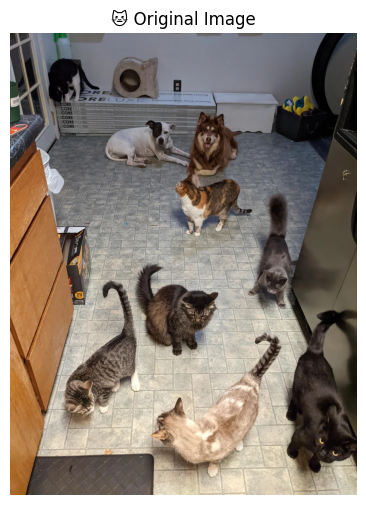

In [54]:
import cv2
import matplotlib.pyplot as plt

# 이미지 경로 설정 (업로드된 파일 경로 확인 필수!)
img_path = "/content/catsanddogs.png"  # Colab 환경에서는 /content/에 업로드됨

# 이미지 불러오기 (OpenCV는 BGR로 로드되므로 RGB로 변환)
img_orig = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")  # 축 제거
plt.title("🐱 Original Image")
plt.show()

In [61]:
# 이미지 전처리 변환 (PyTorch 모델 입력 형태로 변환)
transform = transforms.Compose([
    transforms.ToTensor(),  # Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

# 입력 텐서 변환 및 배치 차원 추가
input_tensor = transform(img_rgb).unsqueeze(0)

# 모델 입력을 GPU로 보낼 수 있으면 GPU 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
input_tensor = input_tensor.to(device)

print(f"✅ 이미지 전처리 완료! (Device: {device})")

✅ 이미지 전처리 완료! (Device: cuda)


In [64]:
# 모델 예측 수행 (출력 확인)
with torch.no_grad():
    output = model(input_tensor)

# 출력의 키 확인
print("🔑 모델 출력 키:", output.keys())

🔑 모델 출력 키: odict_keys(['logits'])


In [65]:
# 올바른 키를 사용해 세그멘테이션 맵 추출
key_name = list(output.keys())[0]  # 첫 번째 키를 가져옴 (예: "out" 또는 "logits")
seg_map = output[key_name][0].argmax(0).cpu().numpy()

# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

🔍 감지된 클래스 ID: [  0   3  10  12  15  17  24  37  40  41  43  50  71  81  89  98 107 108
 112 115 125 126 137 138 139 146]


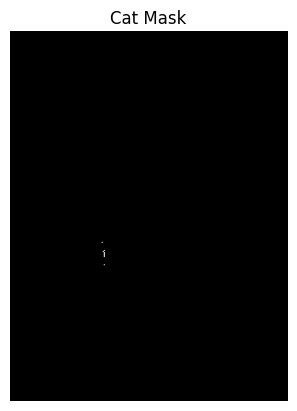

In [66]:
# 고양이 클래스 ID
cat_class_id = 17

# 고양이 마스크 생성 (seg_map에서 값이 17인 부분만 True)
cat_mask = (seg_map == cat_class_id)

# 마스크 시각화
plt.imshow(cat_mask, cmap='gray')
plt.axis("off")
plt.title("Cat Mask")
plt.show()

In [68]:
# 마스크 크기 조정 (원본 이미지 크기에 맞게 변경)
cat_mask_resized = cv2.resize(cat_mask.astype(np.uint8), (img_rgb.shape[1], img_rgb.shape[0]))

# 1채널 → 3채널 변환 (RGB 마스크 만들기)
cat_mask_3ch = np.stack([cat_mask_resized]*3, axis=-1)

# 크기 확인
print("✅ Resized Mask Shape:", cat_mask_3ch.shape)
print("✅ Original Image Shape:", img_rgb.shape)

✅ Resized Mask Shape: (1440, 1080, 3)
✅ Original Image Shape: (1440, 1080, 3)


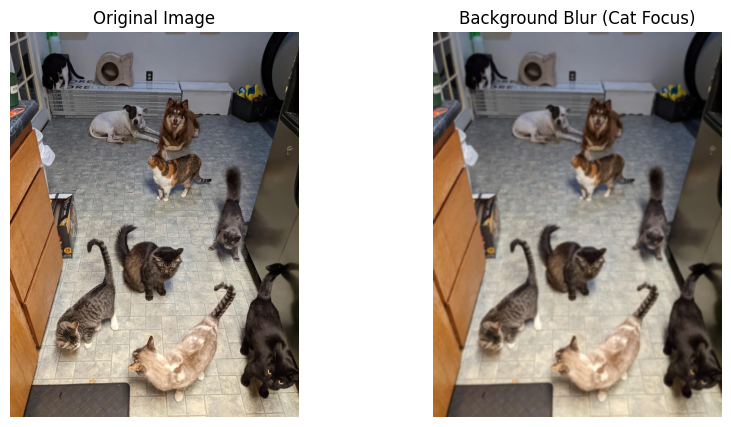

In [69]:
# 원본 이미지 블러 처리
img_blur = cv2.GaussianBlur(img_rgb, (15,15), 0)  # 블러 강도 조정 가능

# 배경만 블러 적용 (고양이 부분만 원본 유지)
img_result = np.where(cat_mask_3ch == 1, img_rgb, img_blur)

# 최종 결과 시각화
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(img_result)
plt.axis("off")
plt.title("Background Blur (Cat Focus)")

plt.show()

In [57]:
# 모델 예측 수행
with torch.no_grad():
    outputs = model(**inputs)

# 출력 logits을 가장 높은 확률을 가진 클래스로 변환
logits = outputs.logits
seg_map = logits.argmax(dim=1).squeeze().cpu().numpy()

print("✅ 세그멘테이션 완료!")

✅ 세그멘테이션 완료!


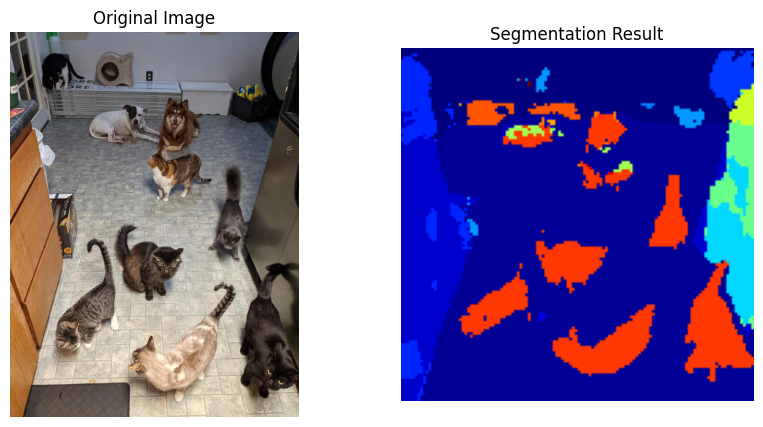

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# 세그멘테이션 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 세그멘테이션 결과 (색상맵 적용)
plt.subplot(1, 2, 2)
plt.imshow(seg_map, cmap="jet")
plt.axis("off")
plt.title("Segmentation Result")

plt.show()

In [59]:
# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

🔍 감지된 클래스 ID: [  0   3   4   7  10  12  13  24  27  37  41  50  71  81  89 108 112 115
 121 126 137 148]


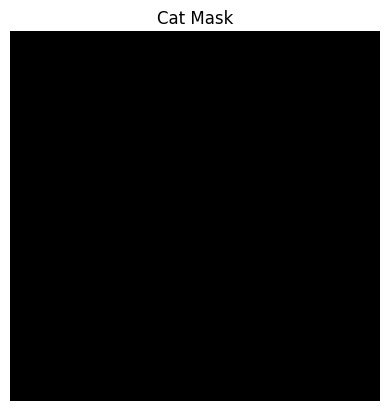

In [60]:
# ADE20K 데이터셋에서 고양이 클래스 ID를 확인 (일반적으로 8 또는 15)
cat_class_id = 8  # 필요하면 실제 감지된 ID로 변경

# 고양이 마스크 생성 (고양이 부분만 True)
cat_mask = seg_map == cat_class_id

# 마스크 시각화
plt.imshow(cat_mask, cmap="gray")
plt.axis("off")
plt.title("Cat Mask")
plt.show()

In [71]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ✅ PyTorch 내장 DeepLabV3+ 모델 (COCO 데이터셋 기반)
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # 평가 모드로 설정
print("✅ DeepLabV3+ (COCO) 모델 로딩 완료!")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ DeepLabV3+ (COCO) 모델 로딩 완료!


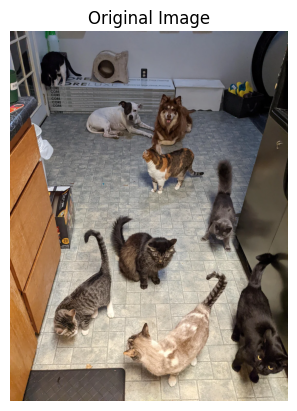

In [72]:
import cv2
import matplotlib.pyplot as plt

# OpenCV를 사용하여 이미지 로드
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [73]:
# 이미지 로드 및 전처리
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Tensor 변환
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 모델 정규화
])

# 이미지 로드 (OpenCV: BGR → RGB 변환 필수)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_tensor = transform(img_rgb).unsqueeze(0)  # 배치 차원 추가

print("✅ 이미지 전처리 완료! Shape:", img_tensor.shape)

✅ 이미지 전처리 완료! Shape: torch.Size([1, 3, 1440, 1080])


In [74]:
# 모델 예측 수행
with torch.no_grad():
    output = model(img_tensor)["out"][0]  # 모델 출력 중 "out" 키 사용

# 출력 logits을 가장 높은 확률의 클래스로 변환
seg_map = output.argmax(0).cpu().numpy()

# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

🔍 감지된 클래스 ID: [ 0  5  8 12]


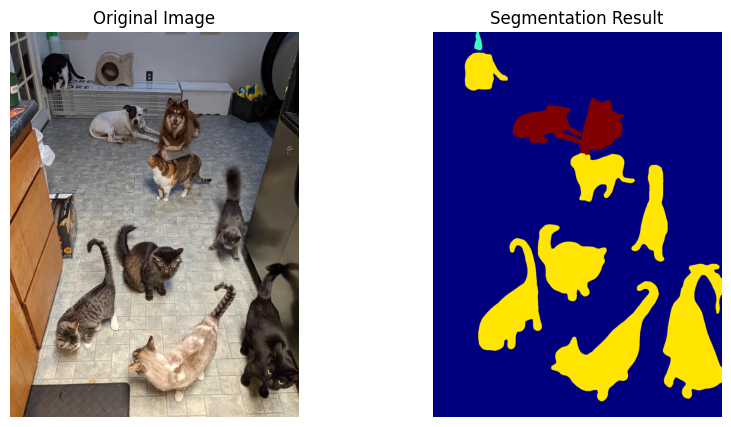

In [75]:
# 세그멘테이션 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 세그멘테이션 결과 출력
plt.subplot(1, 2, 2)
plt.imshow(seg_map, cmap="jet")  # 컬러맵 적용
plt.axis("off")
plt.title("Segmentation Result")

plt.show()

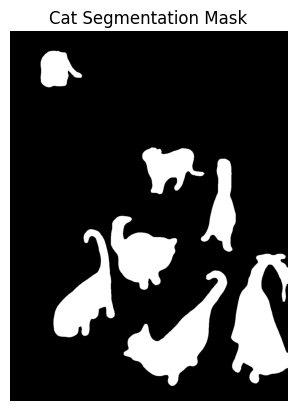

In [76]:
# COCO 데이터셋에서 고양이 클래스 ID
cat_class_id = 8  # 고양이
dog_class_id = 12  # 개 (참고)

# 고양이 영역만 선택한 마스크 생성
cat_mask = (seg_map == cat_class_id)

# 고양이 마스크 시각화
plt.imshow(cat_mask, cmap="gray")
plt.axis("off")
plt.title("Cat Segmentation Mask")
plt.show()

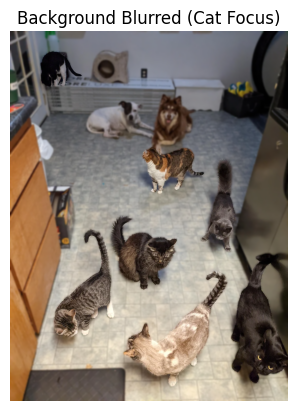

In [77]:
# 이미지 블러 처리 (커널 크기 조정 가능)
img_blur = cv2.GaussianBlur(img_rgb, (15, 15), 0)

# 고양이 영역을 제외한 배경 마스크 생성
background_mask = np.where(cat_mask, 0, 1).astype(np.uint8)

# 마스크 확장 (1채널 → 3채널 변환)
background_mask_3ch = cv2.cvtColor(background_mask * 255, cv2.COLOR_GRAY2BGR)

# 배경만 블러 적용 (고양이 부분만 원본 유지)
img_result = np.where(background_mask_3ch == 255, img_blur, img_rgb)

# 결과 시각화
plt.imshow(img_result)
plt.axis("off")
plt.title("Background Blurred (Cat Focus)")
plt.show()

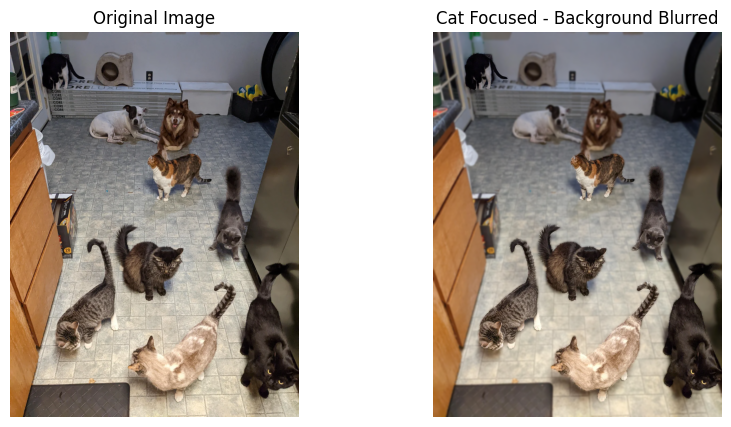

In [78]:
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 고양이만 선명한 결과
plt.subplot(1, 2, 2)
plt.imshow(img_result)
plt.axis("off")
plt.title("Cat Focused - Background Blurred")

plt.show()

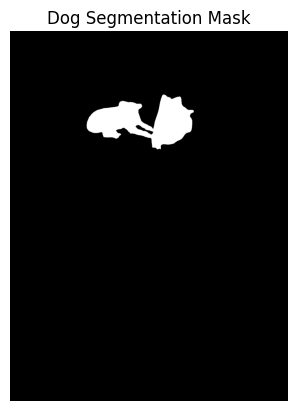

In [79]:
# 강아지 클래스 ID (COCO 데이터셋 기준)
dog_class_id = 12  # 🐶 강아지

# 강아지 영역만 선택한 마스크 생성
dog_mask = (seg_map == dog_class_id)

# 강아지 마스크 시각화
plt.imshow(dog_mask, cmap="gray")
plt.axis("off")
plt.title("Dog Segmentation Mask")
plt.show()

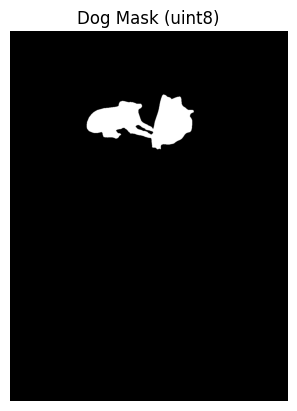

In [80]:
# 강아지 마스크를 uint8 타입으로 변환 (0 또는 255)
dog_mask_uint8 = (dog_mask.astype(np.uint8) * 255)

# 마스크 시각화 (확인용)
plt.imshow(dog_mask_uint8, cmap="gray")
plt.axis("off")
plt.title("Dog Mask (uint8)")
plt.show()

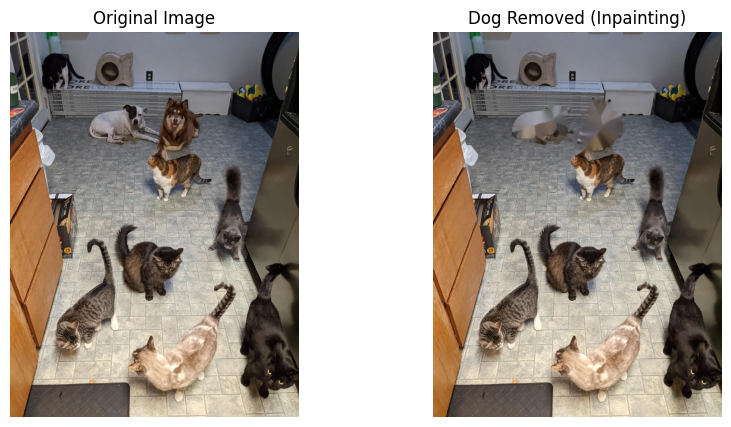

In [81]:
# OpenCV의 Telea 알고리즘을 이용한 인페인팅
img_inpainted = cv2.inpaint(img_rgb, dog_mask_uint8, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

# 결과 시각화
plt.figure(figsize=(10, 5))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

# 강아지 제거된 이미지 (인페인팅 적용)
plt.subplot(1, 2, 2)
plt.imshow(img_inpainted)
plt.axis("off")
plt.title("Dog Removed (Inpainting)")

plt.show()

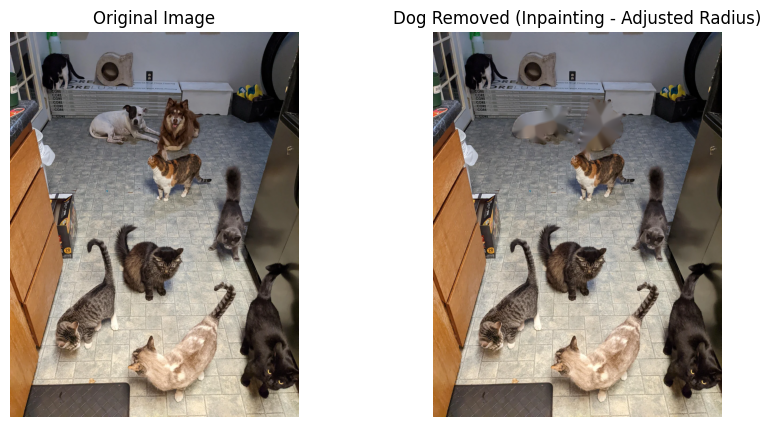

In [82]:
# inpaintRadius 값을 5 → 10으로 증가
img_inpainted = cv2.inpaint(img_rgb, dog_mask_uint8, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

# 결과 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_inpainted)
plt.axis("off")
plt.title("Dog Removed (Inpainting - Adjusted Radius)")

plt.show()

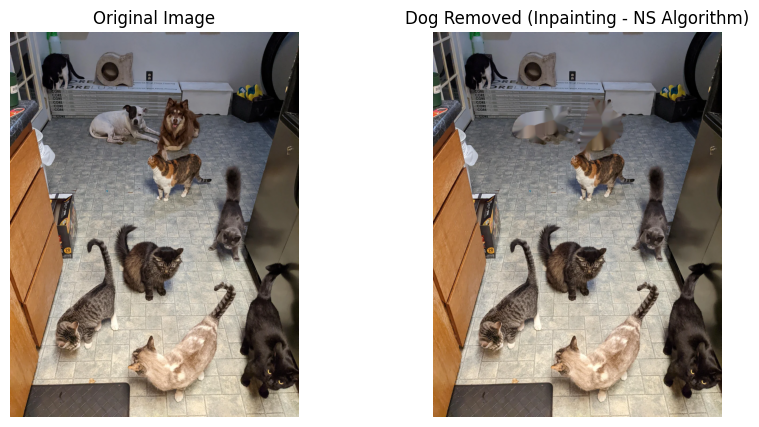

In [83]:
# INPAINT_NS 알고리즘 적용
img_inpainted_ns = cv2.inpaint(img_rgb, dog_mask_uint8, inpaintRadius=10, flags=cv2.INPAINT_NS)

# 결과 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_inpainted_ns)
plt.axis("off")
plt.title("Dog Removed (Inpainting - NS Algorithm)")

plt.show()

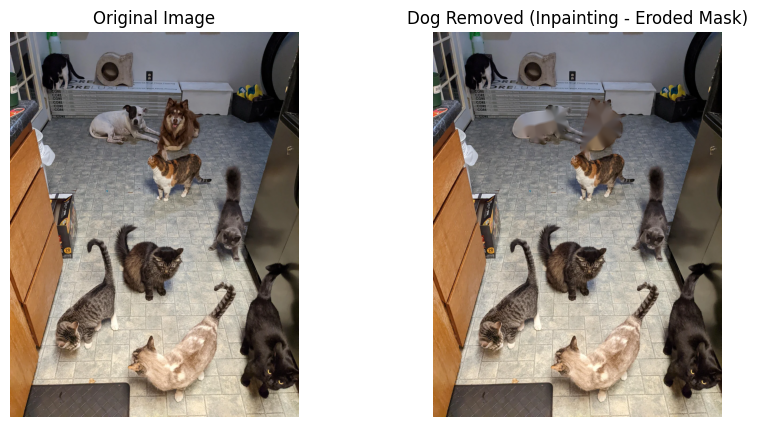

In [84]:
# 마스크 크기 축소 (침식 연산)
kernel = np.ones((5, 5), np.uint8)  # 5x5 커널 사용
dog_mask_eroded = cv2.erode(dog_mask_uint8, kernel, iterations=1)

# 새로운 마스크로 인페인팅
img_inpainted_eroded = cv2.inpaint(img_rgb, dog_mask_eroded, inpaintRadius=10, flags=cv2.INPAINT_TELEA)

# 결과 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_inpainted_eroded)
plt.axis("off")
plt.title("Dog Removed (Inpainting - Eroded Mask)")

plt.show()

In [85]:
from google.colab import files

# 파일 업로드 (Colab에서 실행하면 직접 파일 선택 가능)
uploaded = files.upload()

# 업로드된 파일 확인
import os
for filename in uploaded.keys():
    print(f"📂 업로드된 파일: {filename}")
    new_bg_path = f"/content/{filename}"  # 업로드된 파일 경로 설정

print(f"✅ 새로운 배경 이미지 경로: {new_bg_path}")

Saving bc.png to bc.png
📂 업로드된 파일: bc.png
✅ 새로운 배경 이미지 경로: /content/bc.png


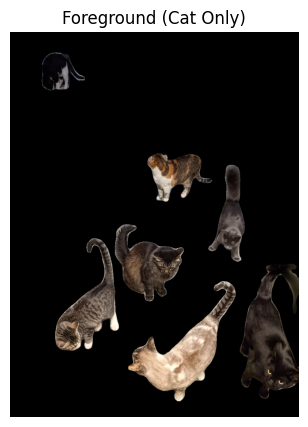

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 마스크를 3채널로 확장 (흑백 → 컬러)
cat_mask_3ch = np.stack([cat_mask] * 3, axis=-1)

# 배경을 투명하게 만들기 (배경 = 0, 고양이 부분 유지)
img_fg = np.where(cat_mask_3ch, img_rgb, (0, 0, 0))  # 배경을 검정색(0,0,0)으로 변경

# 결과 확인
plt.figure(figsize=(10, 5))
plt.imshow(img_fg)
plt.axis("off")
plt.title("Foreground (Cat Only)")
plt.show()

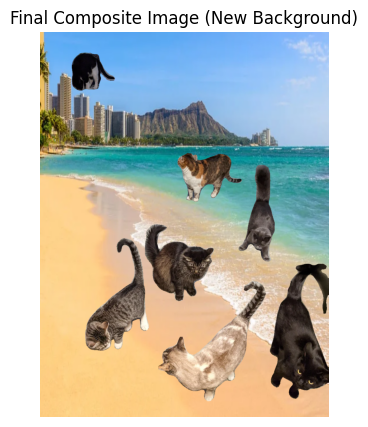

In [87]:
# 새로운 배경 이미지 불러오기
new_bg = cv2.imread(new_bg_path)
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

# 새로운 배경을 원본 이미지 크기로 리사이즈
new_bg_resized = cv2.resize(new_bg, (img_rgb.shape[1], img_rgb.shape[0]))

# 배경을 새로운 이미지로 바꾸기 (배경=1, 고양이=0)
img_final = np.where(cat_mask_3ch, img_rgb, new_bg_resized)

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.imshow(img_final)
plt.axis("off")
plt.title("Final Composite Image (New Background)")
plt.show()

#Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

In [89]:
from google.colab import files

uploaded = files.upload()  # 로컬에서 이미지 업로드

Saving IMG_2352.png to IMG_2352.png


In [91]:
import os

# 업로드된 파일 목록 확인
print("📂 현재 Colab에 업로드된 파일 목록:")
os.listdir("/content/")

# 불러올 이미지 경로 설정 (업로드한 이미지 파일명으로 변경)
img_path = "/content/IMG_2352.png"  # 예시: "new_image.jpg"
print(f"✅ 이미지 경로 설정 완료: {img_path}")

📂 현재 Colab에 업로드된 파일 목록:
✅ 이미지 경로 설정 완료: /content/IMG_2352.png


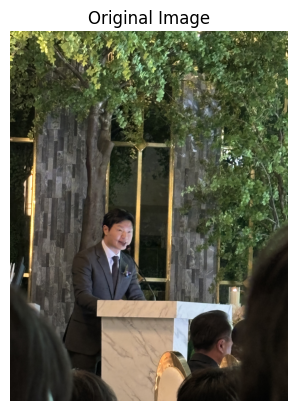

In [92]:
import cv2
import matplotlib.pyplot as plt

# 이미지 불러오기 (BGR -> RGB 변환 필요)
img_orig = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)  # OpenCV는 기본적으로 BGR로 이미지를 불러옴

# 이미지 시각화
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")
plt.show()

#Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

아웃포커싱 하는 법
얕은 피사계 심도 촬영의 이해
3D Camera 활용하기
이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.

3D 이미지센서
소프트웨어 기술 활용하기
하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.

Unsupervised Learning of Depth and Ego-Motion: A Structured Approach
content img
딥러닝이 발전한 지금은 더 다양한 기술이 개발되어 있으니 잘 탐색해 보세요.

다른 기술과 융합해 보기
구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

uDepth: Real-time 3D Depth Sensing on the Pixel 4
이렇게 카메라와 무관한 다른 기술과 융합하는 것도 좋은 해결책이 될 수 있습니다. 한 번 고민해 보세요!

이 외에도 다른 방식으로 접근해도 좋습니다. 엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

In [93]:
import torch
import torchvision
from torchvision import transforms
import numpy as np

# ✅ PyTorch 내장 DeepLabV3+ 모델 (COCO 데이터셋 기반)
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # 평가 모드로 설정
print("✅ DeepLabV3+ (COCO) 모델 로딩 완료!")

# 이미지 전처리 (모델 입력 사이즈 맞추기)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),  # 모델 기본 입력 크기
    transforms.ToTensor(),
])

# 이미지 변환 및 모델 입력 준비
input_tensor = preprocess(img_rgb).unsqueeze(0)  # 배치 차원 추가
print("✅ 이미지 전처리 완료!")

# 모델 예측 수행
with torch.no_grad():
    output = model(input_tensor)["out"][0]  # 모델 출력 중 "out" 키를 사용

# 출력 logits을 가장 높은 확률의 클래스로 변환
seg_map = output.argmax(0).cpu().numpy()

# 감지된 클래스 ID 확인
unique_classes = np.unique(seg_map)
print("🔍 감지된 클래스 ID:", unique_classes)

✅ DeepLabV3+ (COCO) 모델 로딩 완료!
✅ 이미지 전처리 완료!
🔍 감지된 클래스 ID: [ 0 15]


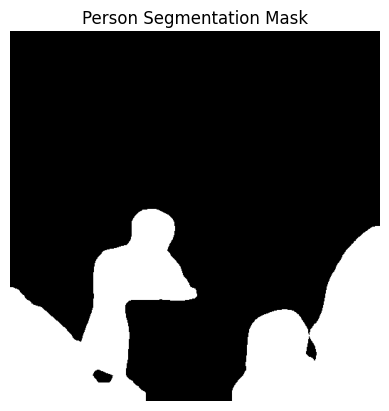

In [94]:
# 사람 클래스 ID
person_class_id = 15

# 사람만 포함하는 마스크 생성
person_mask = (seg_map == person_class_id)

# 마스크 시각화
plt.imshow(person_mask, cmap="gray")
plt.axis("off")
plt.title("Person Segmentation Mask")
plt.show()

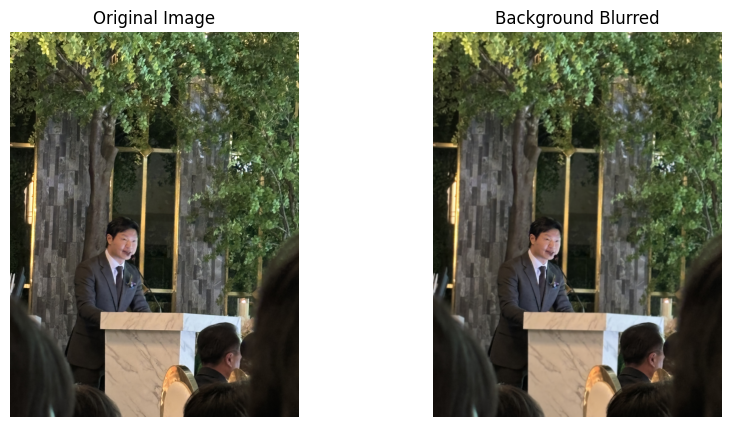

In [96]:
# person_mask를 원본 이미지 크기로 리사이즈
person_mask_resized = cv2.resize(person_mask.astype(np.uint8), (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# 마스크를 3채널로 확장
person_mask_3ch = np.repeat(person_mask_resized[:, :, np.newaxis], 3, axis=2)

# 인물 부분은 원본, 배경은 블러 처리
img_result = np.where(person_mask_3ch, img_rgb, img_blur)

# 결과 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_result)
plt.axis("off")
plt.title("Background Blurred")

plt.show()